# Análisis de Series Temporales
## Laboratorio 1

Estudiante: Ing. Luis Epifanio (luis.epifanio@gmail.com)

# 1. Consigna

1) Levantar los datos desde el archivo dataset/Telefonia_movil.csv. Los mismos fueron extraídos de http://datosabiertos.enacom.gob.ar/visualizations/29890/trafico-de -suscriptores-de-telefonia-movil-miles-de-minutos/ 

> Ver apartado [2.1. Carga y Limpieza de Datos](#2.1.-Carga-y-Limpieza-de-Datos)

2) Explorar los datos, visualizarlos.

> Ver apartado [2.2.-Análisis-Exploratorio](#2.2.-Análisis-Exploratorio.)

3) Implementar dos modelos (como ser Random Walk (Naïve) y Exponential Smoothing).

> Ver apartado [2.3.-Implementación-de-Modelos](#2.3.-Implementación-de-Modelos)
>
> -[2.3.1.-Random-Walk-(Naïve)](#2.3.1.-Random-Walk-(Naïve))
>
> -[2.3.2.-Exponential-Smoothing](#2.3.2.-Exponential-Smoothing)

4) Visualizar los resultados y evaluarlos, comparando ambas implementaciones.

> Ver apartado [4.-Comparación-y-Selección-del-Modelo](#4.-Comparación-y-Selección-del-Modelo)


# 2. Desarrollo

## 2.1. Carga y Limpieza de Datos

Correspondiente al punto 1: Levantar los datos desde el archivo dataset/Telefonia_movil.csv. Los mismos fueron extraídos de http://datosabiertos.enacom.gob.ar/visualizations/29890/trafico-de -suscriptores-de-telefonia-movil-miles-de-minutos/

In [1]:
from plotting import fanchart
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

Algunas funciones y configuracioens de soporte

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
green='#227722'
blue='#1F77B4'
black='#000000'
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('ggplot')

In [4]:
def asQuarter(year, quarter):
    return str(year) + 'Q' + str(quarter)

In [5]:
# Load
data = pd.read_csv('datasets/Telefonia_movil.csv', parse_dates=True, dayfirst=True, thousands='.')
#Create Quarter column as new index to be
data['quarter'] = data.apply(lambda x: asQuarter(x['Año'], x['Trimestre']), axis=1)
data['quarter'] = pd.to_datetime(data.quarter).dt.to_period('Q')
data=data.set_index('quarter')
#Drop some columns not needed
if ({'Año', 'Trimestre','Periodo'}.issubset(data.columns)):
    data.drop(['Año', 'Trimestre', 'Periodo'], axis=1, inplace=True)
#Rename columns for simplicity
data.rename(columns={
    'Minutos pospago salientes (miles)' : 'pospago', 
    'Minutos prepago salientes (miles)' : 'prepago', 
    'Total de minutos salientes (miles)': 'total'

}, inplace=True)
#TODO use PeriodIndex to build index
data.head(5)

,pospago,prepago,total
quarter,,,
2013Q1,8785943,6582117,15368060
2013Q2,9512689,7108640,16621329
2013Q3,10315484,7335154,17650638
2013Q4,9809515,6250549,16060064
2014Q1,10128751,5799223,15927974


In [6]:
display(data.dtypes)

pospago    int64
prepago    int64
total      int64
dtype: object

In [7]:
data.isnull().sum(axis = 0)

pospago    0
prepago    0
total      0
dtype: int64

## 2.2. Análisis Exploratorio.

Correspondiente al punto 2: Explorar los datos, visualizarlos.

In [8]:
data.tail()

,pospago,prepago,total
quarter,,,
2017Q2,15315167,6293563,21608730
2017Q3,15106275,6308373,21414647
2017Q4,14164552,5380710,19545262
2018Q1,13851254,5958717,19809971
2018Q2,14388755,6290155,20678910


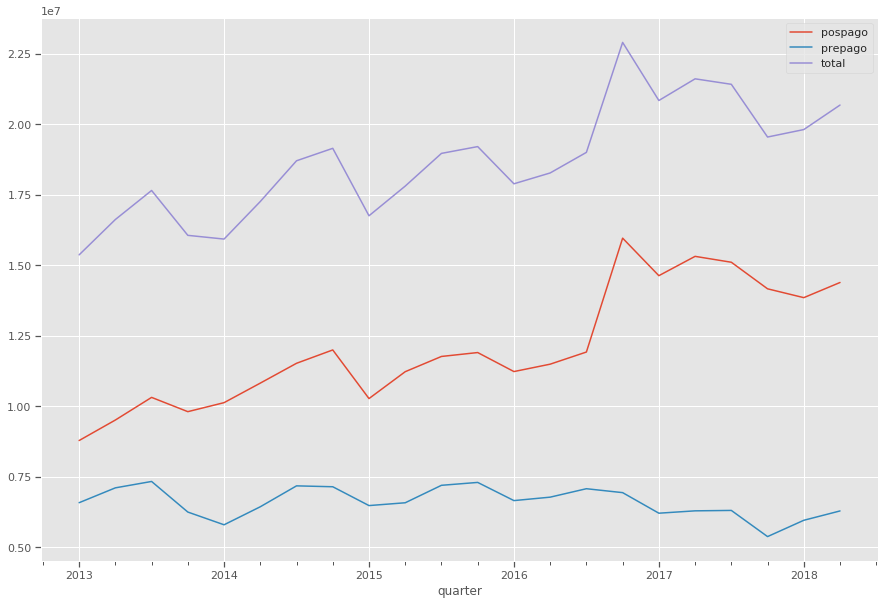

In [9]:
data.plot()

La serie que tomaremos como foco de analisis será la correspondiente a `Minutos pospago salientes (miles)` o en nuesto dataset `'pospago'`

In [10]:
serie_name = 'pospago'
y=data[serie_name]

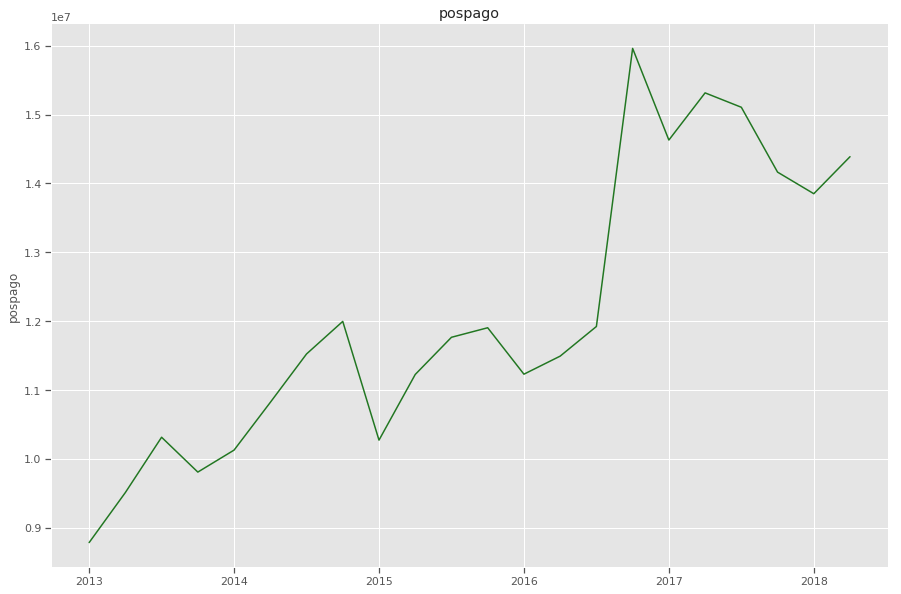

In [11]:
fig, ax= plt.subplots()
y.plot(color=green)
ax.set_xlabel('')
ax.set_ylabel(serie_name)
ax.set_title(serie_name)
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

In [12]:
y.describe().round(2)

count          22.00
mean     12096907.36
std       2077348.52
min       8785943.00
25%      10441978.75
50%      11645527.50
75%      14086227.50
max      15960765.00
Name: pospago, dtype: float64

## 2.3. Implementación de Modelos

Correspondiente al punto 3: Implementar dos modelos (como ser Random Walk (Naïve) y Exponential Smoothing).

### 2.3.1. Random Walk (Naïve)

In [13]:
def analyzeAndPlotRandowWalk(serie):
    h = 4
    test = pd.period_range(
        start=serie.index[-1]+1, 
        periods=h, 
        freq='Q'
    )
    pred = pd.Series(np.repeat(serie.iloc[-1], h), index=test) # the forecast repeats the last observed values h times
    
    print('Predictions:')
    display(pred)
    
    resid=serie-serie.shift(1) # the shift lags the series by one period
    sigma = resid.std()
    round(sigma,3)

    intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                       pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
    
    print('')
    display(intv.round(3))
    
    point_pred = (intv[0]+intv[1])/2

    fig, ax = fanchart(serie['2013Q1':],point_pred,intv,intv,intv)

    plt.show()

Predictions:


2018Q3    14388755
2018Q4    14388755
2019Q1    14388755
2019Q2    14388755
Freq: Q-DEC, dtype: int64

,0,1
2018Q3,1.215453e+07,1.662298e+07
2018Q4,1.122908e+07,1.754843e+07
2019Q1,1.051896e+07,1.825855e+07
2019Q2,9.920301e+06,1.885721e+07


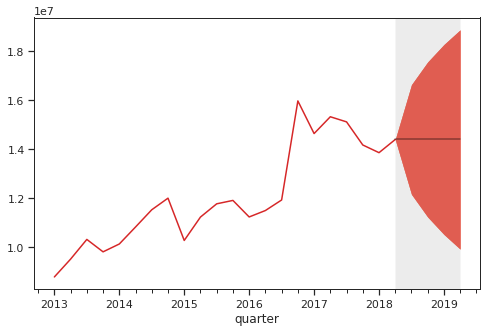

In [14]:
serie_name = 'pospago'
y = data[serie_name]
analyzeAndPlotRandowWalk(y)

In [15]:
naive = y.copy()
naive = naive.shift(1)

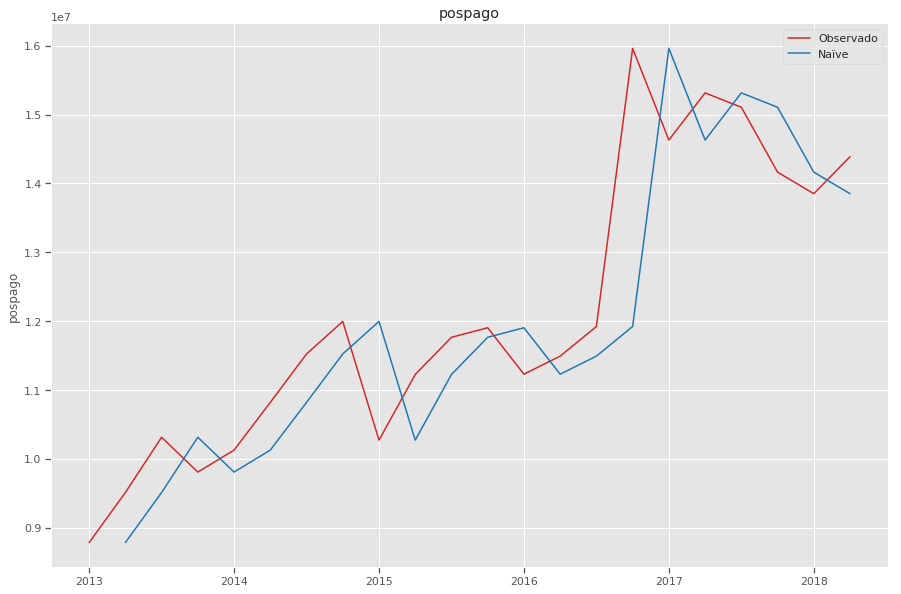

In [16]:
fig, ax= plt.subplots(figsize=(15,10))
y.plot(color=red, label='Observado')
naive.plot(color=blue, label='Naïve')
ax.set_xlabel('')
ax.set_ylabel(serie_name)
ax.set_title(serie_name)
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

### 2.3.2. Exponential Smoothing

#### 2.3.2.1. Modelo y Ajuste con Exponential Smoothing

In [17]:
def analyzeAndPlotExpSmoothing(y):
    model_ses = sm.tsa.SimpleExpSmoothing(y).fit()
    fitted_ses = model_ses.fittedvalues
    # model_ses.summary() # summary isn't implemented in 0.9, looks it'll be avaible in 0.10
    alpha_ses = model_ses.model.params['smoothing_level']
    mse_ses = sm.tools.eval_measures.mse(y,fitted_ses)
    # loglik_ses = model_ses.model.loglike(model_ses.model.params) # NotImplementedError
    aic_ses = model_ses.aic
    bic_ses = model_ses.bic
    print(' Smoothing parameter: alpha  {0:.3f}'.format(alpha_ses))
    print(' In-sample fit:')
    print(' MSE               {0:.3f}'.format(mse_ses))
    print(' AIC               {0:.3f}'.format(aic_ses))
    print(' BIC               {0:.3f}'.format(bic_ses))
    print()
    N = len(y)
    loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
    aic_ses=-2*loglik_ses+2*3
    bic_ses=-2*loglik_ses+np.log(N)*3
    print(' Log-likelihood    %.3f' % (loglik_ses))
    print(' AIC               {0:.3f}'.format(aic_ses))
    print(' BIC               {0:.3f}'.format(bic_ses))
    
    fig, ax= plt.subplots(figsize=(15,10))
    y.plot(color=red, label='Inflation')
    fitted_ses.plot(color='blue', label='Simple exponential smoothing fit', alpha=0.8)
    ax.set_xlabel('')
    ax.set_ylabel('Original')
    ax.set_title('Comparison')
    ax.set_xticks([], minor=True) 
    plt.legend(loc='best')
    sns.despine()
    plt.show()
    
    return fitted_ses


 Smoothing parameter: alpha  0.790
 In-sample fit:
 MSE               1199115338535.890
 AIC               615.877
 BIC               618.059

 Log-likelihood    -337.155
 AIC               680.311
 BIC               683.584


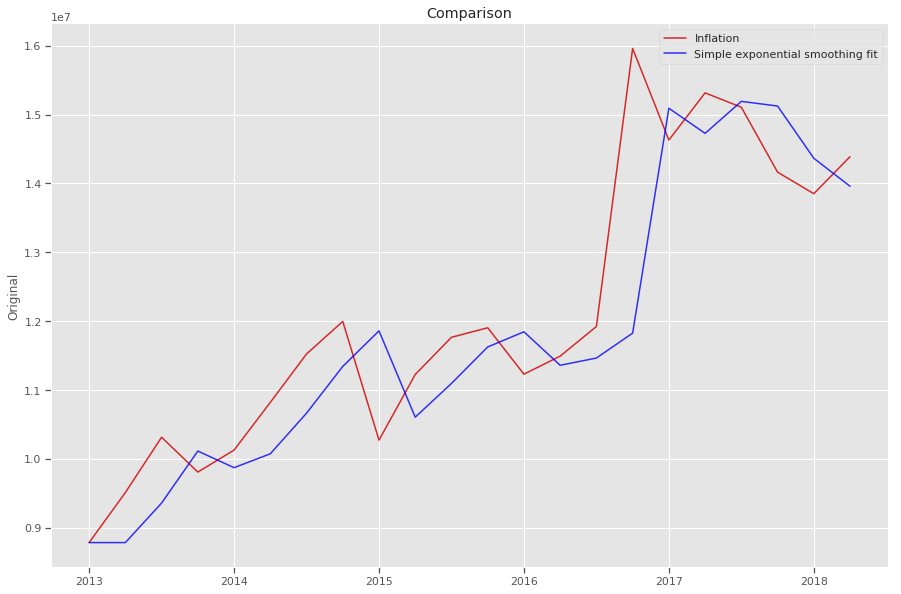

In [18]:
fitted_ses = analyzeAndPlotExpSmoothing(data['pospago'])

#### 2.3.2.2. Diagnóstico del Modelo Generado con Exponential Smoothing

In [19]:
resid=y-fitted_ses 

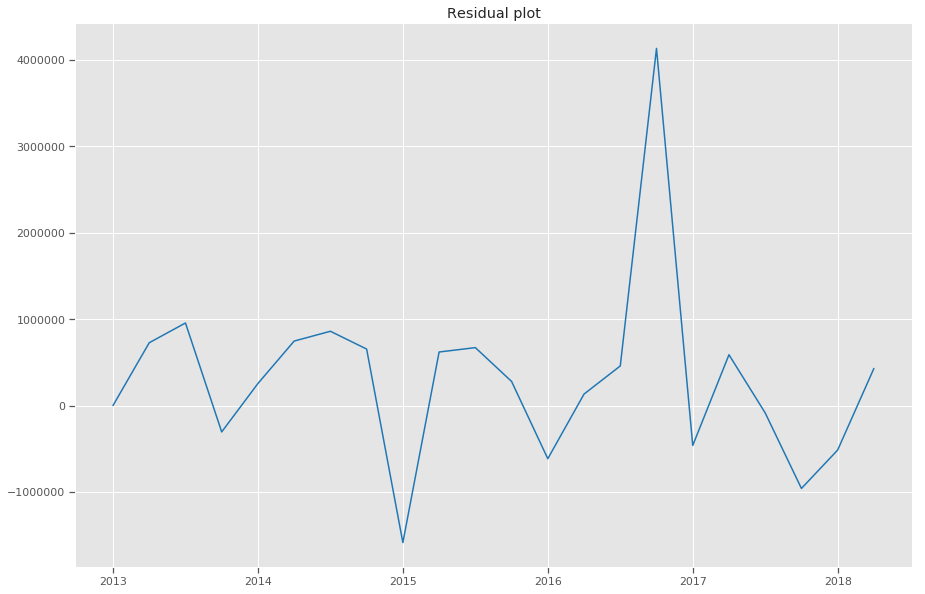

In [20]:
fig, ax= plt.subplots()
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

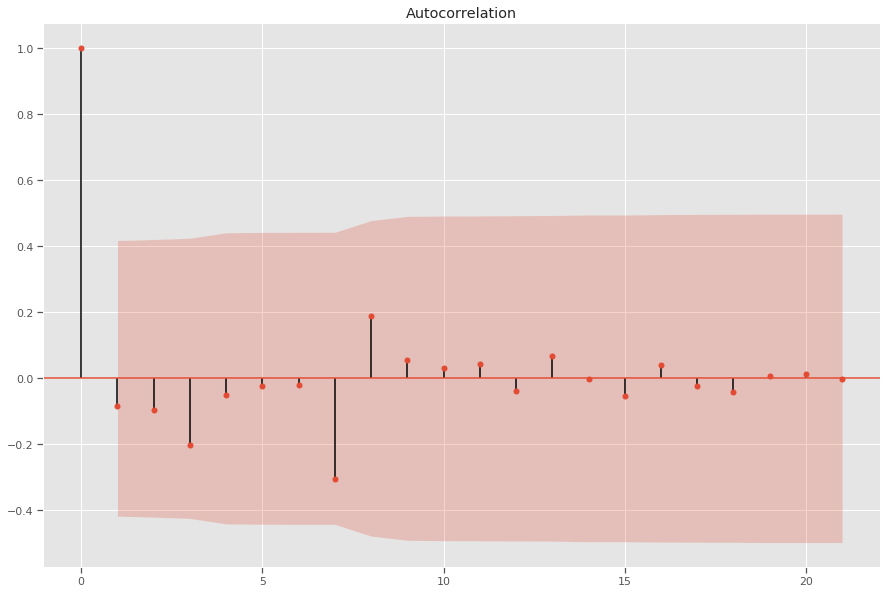

In [21]:
lags_num = len(resid) - 1
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(resid, lags=lags_num, ax=ax)
sns.despine()
plt.show()

/home/luis/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


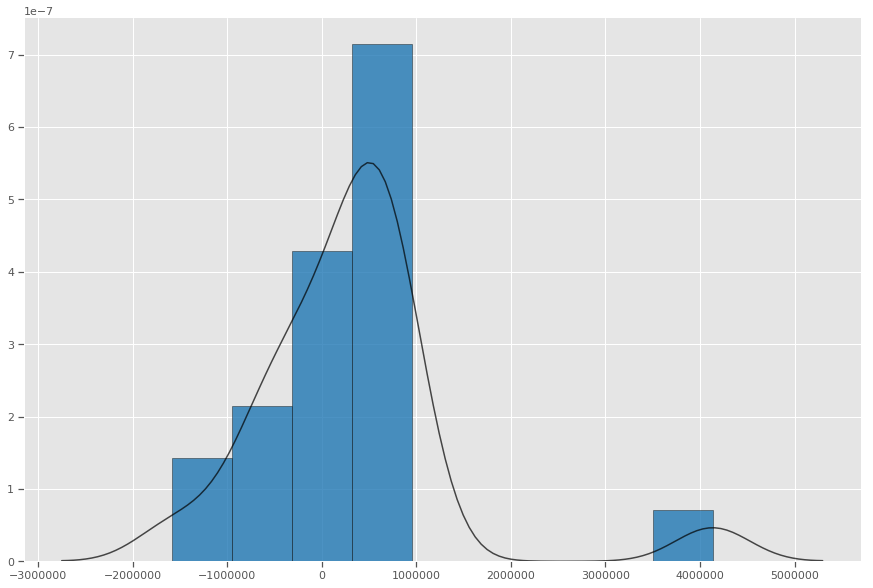

In [22]:
def hist(series):
    fig, ax= plt.subplots()
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

#### 2.3.2.3. Pronóstico con el Modelo Generado con Exponential Smoothing

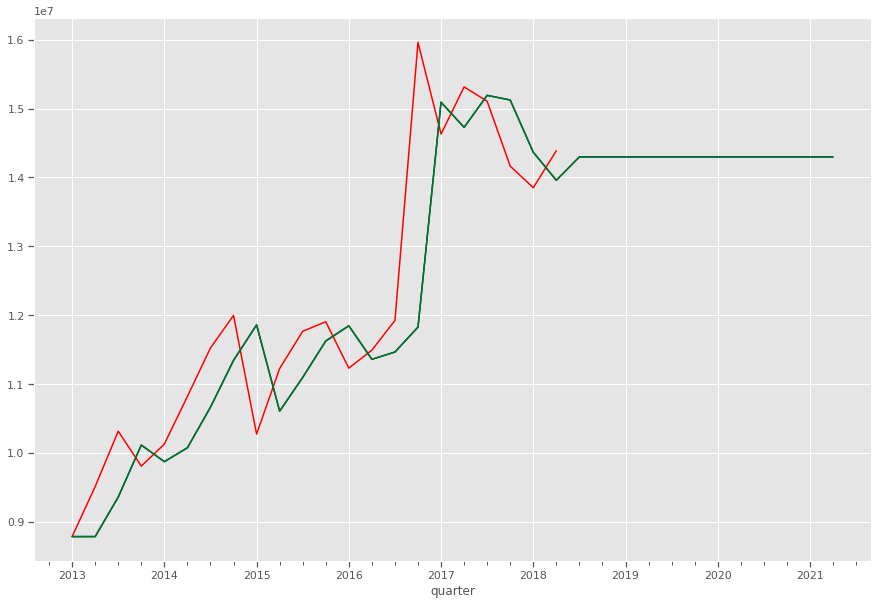

In [23]:
h=12
w=h*10
data = y
model = sm.tsa.SimpleExpSmoothing
pred_index = y.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_fit = None
for i in range(0,h):
    current = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i==0:
        orig_fit = expanding.fittedvalues
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
ax = data[-w:].plot(color='red' )
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_fit[-w:],pred_rolling]).plot(ax=ax,color='green');

# 3. Validación de Modelos

In [24]:
# Real time forecasting - use it as a template - expanding window

validation=y['2016Q1':].index 
start = y.index.get_loc('2016Q1') 

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    actual.append(y.iloc[i]) # actual value
    pred1.append(y.iloc[i-1]) # random walk forecast
    model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)

results_sm.tail()

,RW,SES,Actual
quarter,,,
2017Q2,14630269.0,1.472014e+07,15315167.0
2017Q3,15315167.0,1.518992e+07,15106275.0
2017Q4,15106275.0,1.512391e+07,14164552.0
2018Q1,14164552.0,1.437295e+07,13851254.0
2018Q2,13851254.0,1.395104e+07,14388755.0


In [25]:
from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
RW,1434067.548,470798.727
SES,1470343.261,484247.755


# 4. Comparación y Selección del Modelo 

De la sección inmediata anterior, podemos advertir que Random Walk (Naïve) **(RM)** tiene menor RMSE de validación acorde a los datos utilizados, lo cual lo convierte en el mas conveninete de entre los comparados.Se advierte además una elevada Desviación estándar y un set de datos acotado, por lo que sería conveniente analizar algunos otros modelos, tal como veremos en el práctico numero dos.

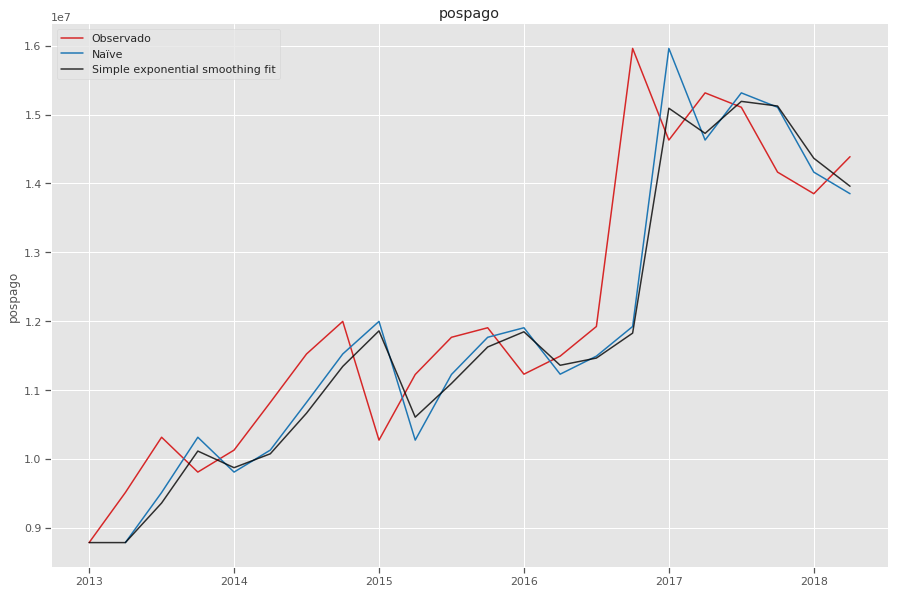

In [26]:
fig, ax= plt.subplots( )
y.plot(color=red, label='Observado')
naive.plot(color=blue, label='Naïve')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel(serie_name)
ax.set_title(serie_name)
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

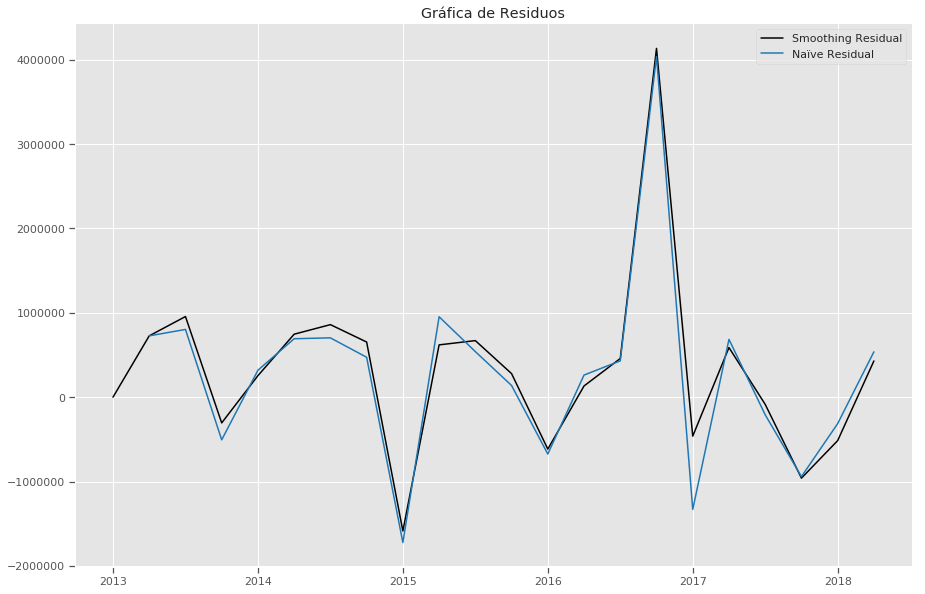

In [27]:
resid_naive=y-y.shift(1)

fig, ax= plt.subplots( )
resid.plot(color=black, label='Smoothing Residual')
resid_naive.plot(color=blue, label='Naïve Residual')
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Gráfica de Residuos')
plt.legend(loc='best')
sns.despine()
plt.show()